In [1]:
import re
import itertools

In [2]:
import os
os.chdir('..')

In [3]:
from itertools import chain, product

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm, trange
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from xgboost import XGBClassifier

In [5]:
from CombineMols.CombineMols import CombineMols

In [6]:
import pygad

In [7]:
from espora import fragmenter

In [8]:
def get_mol(smi):
    return Chem.MolFromSmiles(smi)

In [9]:
def get_mols(mols):
    return [Chem.MolFromSmiles(smi) for smi in mols]

In [10]:
def get_smi(mol):
    return Chem.MolToSmiles(mol)

In [11]:
def get_smis(mols):
    return [get_smi(i) for i in mols]

In [12]:
def get_mw(smi):
    mol = Chem.MolFromSmiles(smi)
    return Descriptors.MolWt(mol)

In [13]:
def grid(mols):
    return Chem.Draw.MolsToGridImage(mols)

In [14]:
def run_fragrank_frag(smis, threhsold_mw=250):
    fragments = [fragmenter.frag_rec(smi) for smi in tqdm(smis, desc="Fragmenting")]
    fragments = [list(filter(lambda x: get_mw(x) < threhsold_mw, fragment)) for fragment in fragments]
    
    unique_subs = set()
    for subs in chain.from_iterable(fragments):
        unique_subs.add(subs)

    G = nx.Graph()
    for sub in unique_subs:
        G.add_node(sub)

    for i in range(len(smis)):
        for j in range(len(fragments[i])):
            for k in range(j+1, len(fragments[i])):
                sub1 = fragments[i][j]
                sub2 = fragments[i][k]
                if G.has_edge(sub1, sub2):
                    G[sub1][sub2]['weight'] += 1
                else:
                    G.add_edge(sub1, sub2, weight=1)

    pr = nx.pagerank(G)
    return pr

In [15]:
df = pd.read_csv("./data/Q16620.csv")
# df = pd.read_csv("./data/Q16602.csv")
# df = pd.read_csv("./data/O14649.csv")
# df = pd.read_csv("./data/P04629.csv")
# df = pd.read_csv("./data/A5PKW4.csv")

In [16]:
df["mw"] = df["canonical_smiles"].apply(lambda x: get_mw(x))

In [17]:
df = df[df["mw"] < 800]

In [18]:
df

,source,id,canonical_smiles,pchembl_value,100 uM,10 uM,1 uM,0.1 uM,augmentation,mw
0,chembl,CHEMBL101311,CN(C)CC(O)COc1ccc(Nc2nccc(Nc3cc(Cl)ccc3Cl)n2)cc1,5.50,1.0,1.0,0.0,0.0,NaN,448.354
1,chembl,CHEMBL103667,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,6.10,1.0,1.0,1.0,0.0,NaN,527.669
2,chembl,CHEMBL104279,Cn1cc(/C=C2\C(=O)Nc3ccc(S(N)(=O)=O)cc32)c2ccccc21,8.12,1.0,1.0,1.0,1.0,NaN,353.403
3,chembl,CHEMBL104333,COc1ccc2c(c1)c(/C=C1\C(=O)Nc3ccc(S(N)(=O)=O)cc...,6.96,1.0,1.0,1.0,0.0,NaN,383.429
4,chembl,CHEMBL104519,CNS(=O)(=O)c1ccc2c(c1)/C(=C/c1cn(C)c3ccc(OC)cc...,7.39,1.0,1.0,1.0,1.0,NaN,397.456
...,...,...,...,...,...,...,...,...,...,...
2919,pubchem,47714912,O=C(Cc1ccc(F)cc1)NNC(=O)Nc1cccc2cnccc12,NaN,0.0,NaN,NaN,NaN,SE,338.342
2920,pubchem,2037329,NC1=NC(c2ccc(F)cc2)C2=C(S1)C(=O)N(c1ccc(Cl)cc1...,NaN,0.0,0.0,0.0,NaN,SE,387.823
2921,pubchem,70341056,CCOC(=O)C(CCc1ccccc1)NC(C)C(=O)N1C(C(=O)OCCSCC...,NaN,0.0,0.0,0.0,NaN,SE,567.705
2922,pubchem,24757729,COc1c(C#Cc2ccc(N3CCN(S(=O)(=O)NC(C)C(=O)O)CC3)...,NaN,0.0,NaN,NaN,NaN,SE,533.650


In [19]:
X = df.canonical_smiles.values
y = df["100 uM"].values

In [20]:
pr = run_fragrank_frag(X[y == 1.0])

Fragmenting:   0%|          | 0/727 [00:00<?, ?it/s]

In [21]:
top_fragments = sorted(pr, key=pr.get, reverse=True)
top_fragments_mols = [Chem.MolFromSmarts(i) for i in top_fragments]

# Replace * with [H] to get all combinations of SMILES

In [22]:
def filler(word, from_char="*", to_char="[H]"):
    options = [(c,) if c != from_char else (from_char, to_char) for c in word]
    return [''.join(o) for o in list(product(*options))]

In [23]:
frags = set()
for i in top_fragments:
    frags.update(filler(i))

In [24]:
frags_ = set()
for smi in frags:
    frags_.add(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))

In [25]:
frag_list_of_list_by_idx = []
for i in range(max([i.count("*") for i in frags_])):
    frag_list_of_list_by_idx.append([])

In [26]:
for i in frags_:
    frag_list_of_list_by_idx[i.count("*")-1].append(i)

In [27]:
def get_molecular_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mw = Descriptors.MolWt(mol)            # Molecular weight
    logp = Descriptors.MolLogP(mol)        # LogP
    tpsa = Descriptors.TPSA(mol)           # Topological polar surface area
    hbd = Descriptors.NumHDonors(mol)      # Number of hydrogen bond donors
    hba = Descriptors.NumHAcceptors(mol)   # Number of hydrogen bond acceptors
    return [mw, logp, tpsa, hbd, hba]

In [28]:
top_10_actives = df.sort_values('pchembl_value', ascending=False).canonical_smiles.iloc[:10].tolist()

In [29]:
top_10_props = []
for i in top_10_actives:
    top_10_props.append(get_molecular_properties(i))
top_10_props = np.array(top_10_props)

In [30]:
prop_ranges = np.array([top_10_props.min(axis=0), top_10_props.max(axis=0)])

In [31]:
def score_properties(properties, prop_range):
    distances = np.maximum(np.maximum(prop_range[0] - properties, 0), np.maximum(properties - prop_range[1], 0))
    score = np.exp(-np.sum(distances))
    return score

In [32]:
def generate_initial_population(population_size):
    population = []
    while len(population) < population_size:
        sample_smis = random.sample(frag_list_of_list_by_idx[0], 2)
        smis = get_smis(CombineMols(sample_smis[0].replace("*", "[I]"), sample_smis[1].replace("*", "[I]"), "I"))
        population.extend(smis)
    return population

In [33]:
# Define the population size, number of generations, and crossover probability
pop_size = 50
num_generations = 20
crossover_prob = 0.7

In [34]:
def create_mol_from_frag(frag1, frag2):
    return random.choice(get_smis(CombineMols(sample_smis[0].replace("*", "[I]"), sample_smis[1].replace("*", "[I]"), "I")))

In [35]:
def fitness_function(ga_instance, smiles, solution_idx):
    props = get_molecular_properties(smiles)
    if props is None:
        return -1000
    score = score_properties(props, prop_ranges)
    return score

In [36]:
def _get_sensible_frag_from_smi(smiles):
    __frag = fragmenter.frag_rec(smiles, max_depth=0)
    __frag = sorted(__frag, key=len)[len(__frag) // 2:]
    return random.choice(__frag)

In [37]:
def _mutate(smiles):
    frag = random.choice(frag_list_of_list_by_idx[0])
    frag_from_smiles = _get_sensible_frag_from_smi(smiles)
    return random.choice(get_smis(CombineMols(frag.replace("*", "[I]"), frag_from_smiles.replace("*", "[I]"), "I")))

In [38]:
def mutation(smiles, mutation_rate):
    if random.random() < mutation_rate:
        return _mutate(smiles)
    return smiles

In [39]:
def crossover(parent1, parent2):
    child1 = random.choice(get_smis(CombineMols(_get_sensible_frag_from_smi(parent1).replace("*", "[I]"), _get_sensible_frag_from_smi(parent2).replace("*", "[I]"), "I")))
    child2 = random.choice(get_smis(CombineMols(_get_sensible_frag_from_smi(parent1).replace("*", "[I]"), _get_sensible_frag_from_smi(parent2).replace("*", "[I]"), "I")))
    return child1, child2

In [40]:
# Define the function that evaluates the molecular properties of a molecule
def evaluate_mol_props(smiles):
    props = get_molecular_properties(smiles)
    if props is None:
        return -1
    score = score_properties(props, prop_ranges)
    return score

In [41]:
# Define the function that selects the best individuals from the population
def selection(population, fitness_func, num_parents):
    fitness_values = [fitness_func(individual) for individual in population]
    fitness_sum = sum(fitness_values)
    fitness_prob = [value/fitness_sum for value in fitness_values]
    parents = random.choices(population, weights=fitness_prob, k=num_parents)
    return parents

In [42]:
# Define the population size, number of generations, and crossover probability
pop_size = 100
num_generations = 50
crossover_prob = 0.7

In [43]:
# Define the initial population with random molecules
population = generate_initial_population(pop_size)

In [44]:
from IPython.display import display, Image

In [45]:
top5_of_each_gen = []

# Run the genetic algorithm for a specified number of generations
for gen in trange(num_generations):
    print(f'Generation {gen+1}:')
    new_population = []
    num_parents = int(pop_size * 0.4)
    parents = selection(population, evaluate_mol_props, num_parents)
    for i in range(0, pop_size - num_parents, 2):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutation(child1, 0.1)
        child2 = mutation(child2, 0.1)
        new_population.append(child1)
        new_population.append(child2)
    population = parents + new_population
    population = sorted(population, key=evaluate_mol_props, reverse=True)[:pop_size]
    best_solution = population[0]
    top5_of_each_gen.append(population[:5])
    best_fitness = evaluate_mol_props(best_solution)
    print(f'Best solution: {best_solution} (fitness={best_fitness})')

  0%|          | 0/10 [00:00<?, ?it/s]

Generation 1:
Best solution: C#Cc1cnc2c(c1)ncn2C(OCC(=O)Nc1cccc(CF)c1)c1ccc(O)cc1 (fitness=1.0)
Generation 2:
Best solution: Nc1c(Cl)ccc(OOc2ccc(-c3cn[nH]c3)nc2C=O)c1Cl (fitness=1.0)
Generation 3:
Best solution: Cc1ccc(-n2nccc2NC(=O)CSc2ccc(OCc3ccc(O)nc3)cc2)cc1 (fitness=1.0)
Generation 4:
Best solution: C#Cc1cnc2c(c1)ncn2C(c1ccc(O)cc1)C1:ccc(-c2cc[nH]c(=O)c2)s:1 (fitness=1.0)
Generation 5:
Best solution: Nc1c(Cl)ccc(OOc2ccc(-c3cn[nH]c3)nc2C=O)c1Cl (fitness=1.0)
Generation 6:
Best solution: Nc1c(Cl)ccc(OOc2ccc(-c3cn[nH]c3)nc2C=O)c1Cl (fitness=1.0)
Generation 7:
Best solution: C#Cc1cnc2c(c1)ncn2C(OCC(=O)C(C)n1cnc2cc(-c3cccnc3)ccc21)c1ccc(O)cc1 (fitness=1.0)
Generation 8:
Best solution: C#Cc1cnc2c(c1)ncn2C(OCC(=O)Nc1cccc(CF)c1)c1ccc(O)cc1 (fitness=1.0)
Generation 9:
Best solution: C#Cc1cnc2c(c1)ncn2C(OCC(=O)Nc1cccc(CF)c1)c1ccc(O)cc1 (fitness=1.0)
Generation 10:
Best solution: Nc1c(Cl)ccc(OOc2ccc(-c3cn[nH]c3)nc2C=O)c1Cl (fitness=1.0)


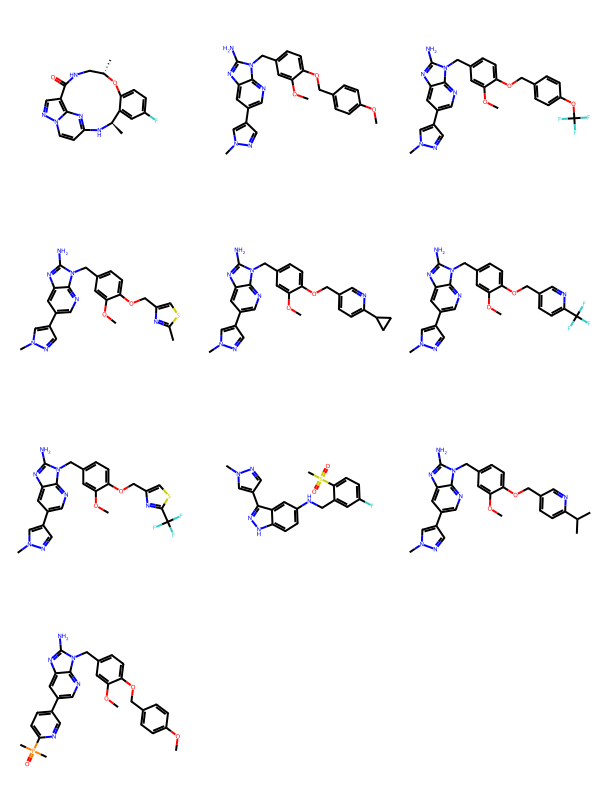

In [47]:
grid(get_mols(top_10_actives))

In [51]:
topmols = list(chain.from_iterable(top5_of_each_gen))

In [54]:
with open("topmols_trkb.smi", "w") as f:
    for i in topmols:
        f.write(f"{i}\n")